In [43]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

### Download the Street Network

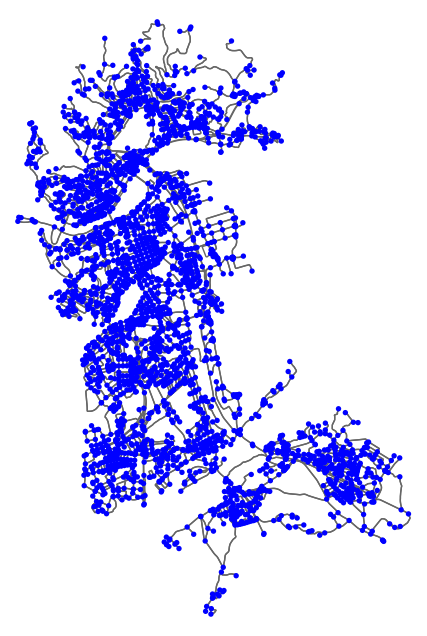

In [27]:
# Define the area
place_name = "Linz, Austria"

# Download street network (driving)
graph = ox.graph_from_place(place_name, network_type='drive')

# Project the map (Convert lat/lon to Meters)
graph_projected = ox.project_graph(graph)

# Plot to see if it worked
ox.plot_graph(graph_projected, bgcolor='white', node_color='blue', edge_color='#666666')
plt.show()


### Generate Synthetic Employee Data

In [34]:
# Get boundary of linz
city_boundary = ox.geocode_to_gdf("Linz, Austria")

# function to create random points inside the boundary (employers)
def generate_random_points(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if random_point.within(poly):
            points.append(random_point)
    return points

# create 200 'Employee homes'
linz_geometry = city_boundary.geometry.iloc[0]
employee_points = generate_random_points(linz_geometry, 200)

# put them in a GeoDataFrame
employees_gdf = gpd.GeoDataFrame(geometry=employee_points, crs="EPSG:4326")

print(f"Generated {len(employees_gdf)} employee home locations within Linz.")


Generated 200 employee home locations within Linz.


### Finding the Hubs (ML Clustering)

In [39]:
# Extract coordinates for clustering
coords = np.array([[p.x, p.y] for p in employees_gdf['geometry']])

# Find 5 optimal shuttle stops
num_hubs = 5
kmeans = KMeans(n_clusters=num_hubs, n_init=10, random_state=33).fit(coords)

# Add cluster ID back to our employees
employees_gdf['hub_id'] = kmeans.labels_

# Get coordinates of the Hubs (Centroids)
hub_centers = kmeans.cluster_centers_

### Visualizing the Result

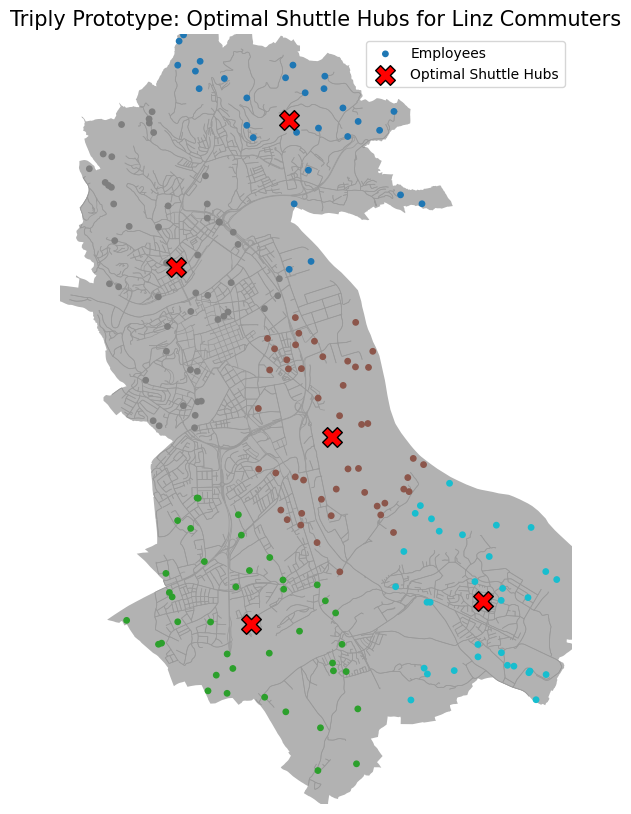

In [42]:
# Visualize the result

fig, ax = plt.subplots(figsize=(10, 10))

# Plot city boundary
city_boundary.plot(ax=ax, color='black', alpha=0.3)

# Plot street network
ox.plot_graph(graph, ax=ax, node_size=0, edge_color='#999999', edge_linewidth=0.5, show=False, close=False)

# Plot employees colored by their assigned hub
employees_gdf.plot(ax=ax, column='hub_id', cmap='tab10', markersize=15, label='Employees')

# Plot the Hubs (The 'Solution')
plt.scatter(hub_centers[:, 0], hub_centers[:, 1], c='red', marker='X', s=200, label='Optimal Shuttle Hubs', edgecolors='black')

plt.title("Triply Prototype: Optimal Shuttle Hubs for Linz Commuters", fontsize=15)
plt.legend()
plt.show()

### Calculate Average Displacement for all employees

In [44]:
# Get distance(in degrees) of each employee to their nearest hub
closest_hub_idx, distances = pairwise_distances_argmin_min(coords, hub_centers)

# Convert degrees to meters (1 deg == 111km)
distance_meters = distances * 111000

avg_dist = np.mean(distance_meters)
print(f"Average distance to shuttle hub: {avg_dist:.2f} meters")

Average distance to shuttle hub: 2140.51 meters
